# Sequential Time Series Forecasting|LSTM|Stock Price Prediction

*The aim of this post is to forecast the Avg. Adj. Close price of Google 12-Weeks Ahead based on the past 12 Weeks observations of the Avg. Weekly Adj. Close prices of Amazon, Netflix & Microsoft. Therefore, for each input sequence, the LSTM task is to predict not only the next value, but the next sequence of predicted values of length equal to the length of the input sequence. The dataset is split into train and test sets to compare the LSTM output sequence against the target test set.*

In [1]:
# Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import hstack
from datetime import datetime
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Selecting the dataset start and end date 
today=datetime.today().strftime('%Y-%m-%d')
start_date=pd.to_datetime('2017-01-01')
end_date=pd.to_datetime(today)

# Use of pandas_datareader.data to get the data from the web
import pandas_datareader.data as pdr

# Importing google,amazon,netflix & microsoft data 
df_amazon =pdr.get_data_yahoo("AMZN",start_date, end_date)
df_netflix=pdr.get_data_yahoo("NFLX",start_date, end_date)
df_microsoft=pdr.get_data_yahoo("MSFT",start_date,end_date)
df_google =pdr.get_data_yahoo("GOOGL",start_date, end_date)

# Creating new dataframe containing only the 'Adj Close' column for each stock 
df = pd.concat([df_amazon['Adj Close'],df_netflix['Adj Close'],df_microsoft['Adj Close'],df_google['Adj Close']], axis=1)
df.columns = ['AMZN_Adj_Close', 'NFLX_Adj_Close','MSFT_Adj_Close', 'GOOGL_Adj_Close']

# Changing the frequency of observations from 'Daily' to 'Weekly' and determining the mean weekly Adj. Close price 
df=df.resample('W').mean()
df.head()

,AMZN_Adj_Close,NFLX_Adj_Close,MSFT_Adj_Close,GOOGL_Adj_Close
Date,,,,
2017-01-08,771.822495,129.945002,58.222105,813.502518
2017-01-15,804.524011,130.843997,58.452179,828.704004
2017-01-22,808.642487,135.790001,58.233751,827.255005
2017-01-29,830.352014,139.686002,59.653789,850.884009
2017-02-05,827.271997,140.432001,59.653787,819.530005


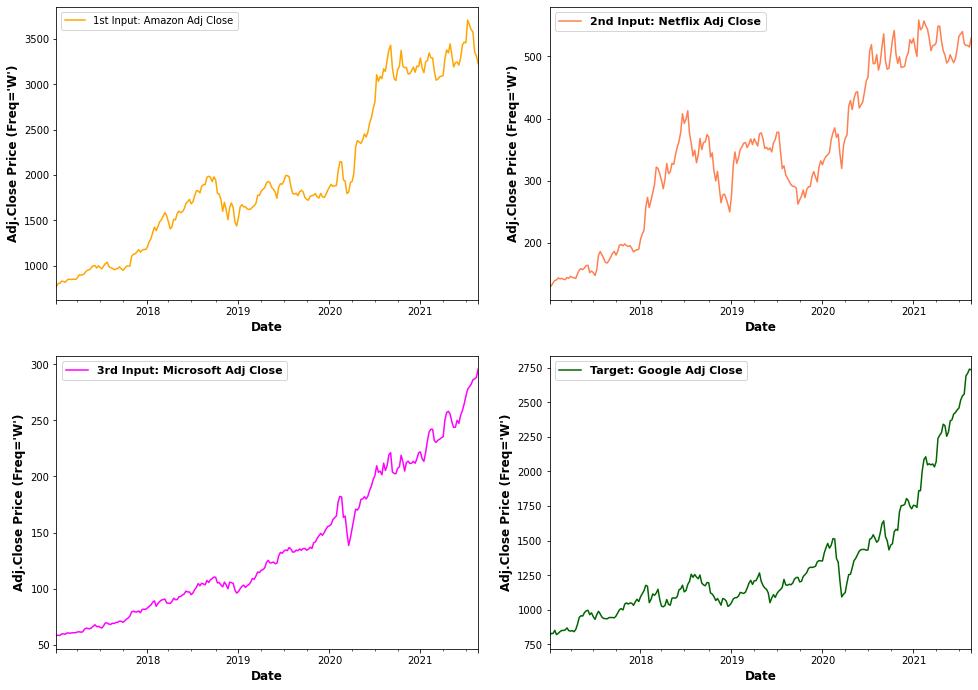

In [2]:
# Google,Amazon,Netflix & Microsoft Ajd.Close price plots
fig,axs=plt.subplots(2,2,figsize=(14,10))

df['AMZN_Adj_Close'].plot(label='1st Input: Amazon Adj Close',c='orange',ax=axs[0,0])
df['NFLX_Adj_Close'].plot(label='2nd Input: Netflix Adj Close',c='coral',ax=axs[0,1])
df['MSFT_Adj_Close'].plot(label='3rd Input: Microsoft Adj Close',c='magenta',ax=axs[1,0])
df['GOOGL_Adj_Close'].plot(label='Target: Google Adj Close',c='darkgreen',ax=axs[1,1])

for ax in axs.flat:
    ax.legend(loc='upper left')
   
    plt.rcParams['font.size']='11'
    plt.rcParams['font.weight']='bold'
    ax.set_xlabel('Date',fontweight='bold',fontsize=12)
    ax.set_ylabel("Adj.Close Price (Freq='W')",fontweight='bold',fontsize=12)
    ax.figure.tight_layout(pad=2);

In [3]:
# Defining the features that comprise the input and output of the LSTM model
in_seq =df[['AMZN_Adj_Close', 'NFLX_Adj_Close','MSFT_Adj_Close']].values
target_seq =df['GOOGL_Adj_Close'].values

# Reshaping the inputs-target shape(length, features_num)
in_seq = in_seq.reshape((len(in_seq), 3))
target_seq = target_seq.reshape((len(target_seq), 1))

# Choosing the length of input & target(prediction horizon) sequence
inp_seq_len= 12
target_seq_len=12
# Splitting the dataset into train and test set

X_train=in_seq[:-target_seq_len]
y_train=target_seq[:-target_seq_len]
X_test=in_seq[-target_seq_len:]
y_test=target_seq[-target_seq_len:]

# Printing the shape of train and test data
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(230, 3) (12, 3)
(230, 1) (12, 1)


In [4]:
# MinMaxScaler is used to transform dataset columns by scaling them between 0 & 1.Training samples are first fitted 
# and then transformed, whereas the test samples are transformed based on the previously fitted training samples in order
# to avoid forecasting with a biased ML model.
from sklearn.preprocessing import MinMaxScaler
scaler_x=MinMaxScaler()
X_train=scaler_x.fit_transform(X_train)
X_test=scaler_x.transform(X_test)
scaler=MinMaxScaler()
y_train=scaler.fit_transform(y_train)
y_test=scaler.transform(y_test)




In [5]:
# Function to create the train input & target sequences

def set_seq(seq, inp_seq_len,target_seq_len):
    X = []
    y = []
    for t in range(len(seq)):
        end = t + inp_seq_len 
        if end+target_seq_len> len(seq):
            break
        
        
        Input_Seq = seq[t:end,:-1]
        Target_Seq = seq[end:end+target_seq_len,-1]
        X.append(Input_Seq)
        y.append(Target_Seq)
    return (np.array(X),np.array(y)) 

In [6]:
# Concatenating the train sequence arrays
from numpy import hstack
df_train = np.concatenate((X_train,y_train),axis=1)

# Creating the training sequences
Xtrain_seq,ytrain_seq=set_seq(df_train, inp_seq_len,target_seq_len)

In [7]:
# The input training data have been converted into 3d shape--> [sample_length,time steps, number of input features]
print(Xtrain_seq.shape)
print(ytrain_seq.shape)

(207, 12, 3)
(207, 12)


In [8]:
print('First Input Train Sequence:\n',Xtrain_seq[0])
print('\r')
print('First Target Train Sequence:\n',ytrain_seq[0].flatten())
print('\r')
print('The First Target Train Sequence consists of the y_train[12:24] samples:\n',y_train[12:24].flatten())

First Input Train Sequence:
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.22344273e-02 2.09881420e-03 1.15113684e-03]
 [1.37752484e-02 1.36458595e-02 5.82701887e-05]
 [2.18973070e-02 2.27415455e-02 7.16319266e-03]
 [2.07449982e-02 2.44831709e-02 7.16318503e-03]
 [1.71766064e-02 3.21920948e-02 5.54134989e-03]
 [2.58682613e-02 2.83866579e-02 1.11857596e-02]
 [3.01347655e-02 3.07644709e-02 1.12255906e-02]
 [2.89151217e-02 2.66777135e-02 1.00979718e-02]
 [2.91425921e-02 2.58605960e-02 1.18890596e-02]
 [3.04318224e-02 3.34948103e-02 1.19453448e-02]
 [2.85911289e-02 3.03664122e-02 1.25454877e-02]]

First Target Train Sequence:
 [0.02047093 0.02293861 0.01760034 0.02799649 0.05226213 0.08455742
 0.09202367 0.0907189  0.10699097 0.11501387 0.11718922 0.09689329]

The First Target Train Sequence consists of the y_train[12:24] samples:
 [0.02047093 0.02293861 0.01760034 0.02799649 0.05226213 0.08455742
 0.09202367 0.0907189  0.10699097 0.11501387 0.11718922 0.09689329]


In [9]:
# Defining the number of input features
features_num = Xtrain_seq.shape[2]
features_num

3

In [10]:
# Importing the necessary libraries to create/construct the neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras import initializers
import tensorflow as tf
tf.random.set_seed(0)
np.random.seed(0)

# Use of the he_uniform initializer to set the initial random weights 
initializer = tf.keras.initializers.he_uniform(seed=0)
model = Sequential()
model.add(LSTM(128, activation='relu',input_shape=(inp_seq_len, features_num),
               kernel_initializer=initializer))
model.add(Dropout(0.1))



# The output layer consists of 12 neurons with a 'linear' activation fuction
model.add(Dense(target_seq_len,activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse')

# Fitting the LSTM model 
model.fit( Xtrain_seq, ytrain_seq,epochs=12, batch_size=1, shuffle=False,verbose=1)

Epoch 1/12
207/207 [==============================] - 0s 1ms/step - loss: 0.0123
Epoch 2/12
207/207 [==============================] - 0s 1ms/step - loss: 0.0097
Epoch 3/12
207/207 [==============================] - 0s 1ms/step - loss: 0.0078
Epoch 4/12
207/207 [==============================] - 0s 1ms/step - loss: 0.0067
Epoch 5/12
207/207 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 6/12
207/207 [==============================] - 0s 1ms/step - loss: 0.0066
Epoch 7/12
207/207 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 8/12
207/207 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 9/12
207/207 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 10/12
207/207 [==============================] - 0s 1ms/step - loss: 0.0056
Epoch 11/12
207/207 [==============================] - 0s 1ms/step - loss: 0.0049
Epoch 12/12
207/207 [==============================] - 0s 1ms/step - loss: 0.0054


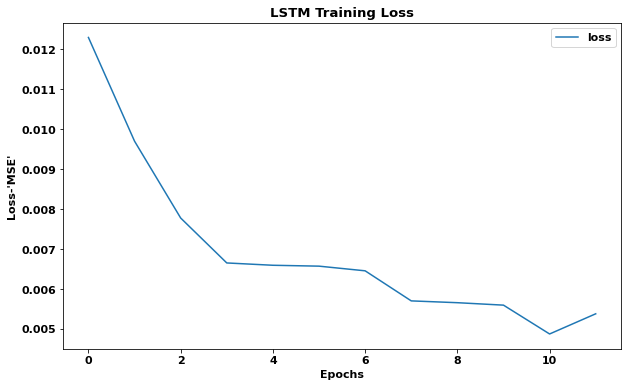

In [11]:
# Training loss plots
loss = pd.DataFrame(model.history.history)

loss.plot(figsize=(10,6))
plt.title('LSTM Training Loss',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("Loss-'MSE'",fontweight='bold');

In [12]:
# Last inp_train seq. Xtrain_seq[-1] corresponds to inputs X_train[-24:-12] as the model is trained to predict 12 steps ahead
# Therefore the last 12 inputs (X_train[-12:]) are to be used to forecast the new output sequence
print('Last input train sequence:  \n')
print(Xtrain_seq[-1])
print('\r')
print("X_train[-24:12]: \n")
print(X_train[-24:-12])

Last input train sequence:  

[[0.90849822 0.92668357 0.78797991]
 [0.90569565 0.91336799 0.81507585]
 [0.94105787 0.93123955 0.81869213]
 [0.90008788 0.89355992 0.78810913]
 [0.88095295 0.86392893 0.7768552 ]
 [0.92558969 1.         0.81681569]
 [0.93062766 0.9633838  0.86754289]
 [0.96220597 0.97114403 0.90802523]
 [0.94243725 0.99686695 0.92012423]
 [0.94171069 0.97895337 0.91951147]
 [0.88485955 0.96614331 0.86826882]
 [0.85035333 0.93250144 0.86129365]]

X_train[-24:12]: 

[[0.90849822 0.92668357 0.78797991]
 [0.90569565 0.91336799 0.81507585]
 [0.94105787 0.93123955 0.81869213]
 [0.90008788 0.89355992 0.78810913]
 [0.88095295 0.86392893 0.7768552 ]
 [0.92558969 1.         0.81681569]
 [0.93062766 0.9633838  0.86754289]
 [0.96220597 0.97114403 0.90802523]
 [0.94243725 0.99686695 0.92012423]
 [0.94171069 0.97895337 0.91951147]
 [0.88485955 0.96614331 0.86826882]
 [0.85035333 0.93250144 0.86129365]]


In [13]:
# LSTM forecasts
new_batch = X_train[-inp_seq_len:].reshape(1,inp_seq_len,features_num)
new_lstm_output = model.predict(new_batch, verbose=0)
print(new_lstm_output)

[[0.9642067  0.9645778  0.9735245  1.0343981  0.99216497 1.0632933
  1.0600184  1.0961258  1.1659058  1.1790208  1.2052312  1.2547219 ]]


In [14]:
# Inverse transforming the scaled outputs and reshaping to convert the lstm_output into 2D shape
new_lstm_output=scaler.inverse_transform(new_lstm_output)
new_lstm_output=new_lstm_output.reshape((-1,1))
new_lstm_output.shape

(12, 1)

In [15]:
# Creating an LSTM predicted values index
new_pred_index=pd.date_range(start=df.index[-target_seq_len],periods=target_seq_len,freq='W')

In [16]:
# Converting the new_lstm_output from np.ndarray to pandas dataframe
new_pred_data=pd.DataFrame(data=new_lstm_output,index=new_pred_index,columns=['LSTM Forecast'])

Text(0.5, 0, 'Date')

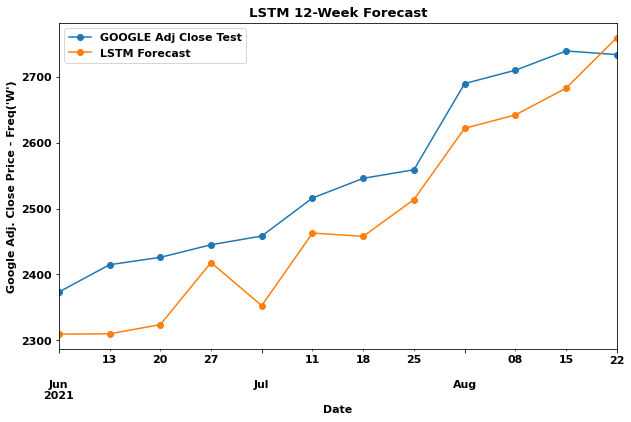

In [25]:
# Plot comprising Google_Adj_Close feature test data & the LSTM forecast

ax=df['GOOGL_Adj_Close'][-target_seq_len:].plot(figsize=(10,6),marker='o',linestyle='-',label='GOOGLE Adj Close Test')
new_pred_data.plot(ax=ax,legend=True,marker='o',linestyle='-')
plt.legend()
plt.title('LSTM 12-Week Forecast',fontweight='bold')
plt.ylabel("Google Adj. Close Price - Freq('W')",fontweight='bold')
plt.xlabel('Date',fontweight='bold')


(2610.0, 2695.0)

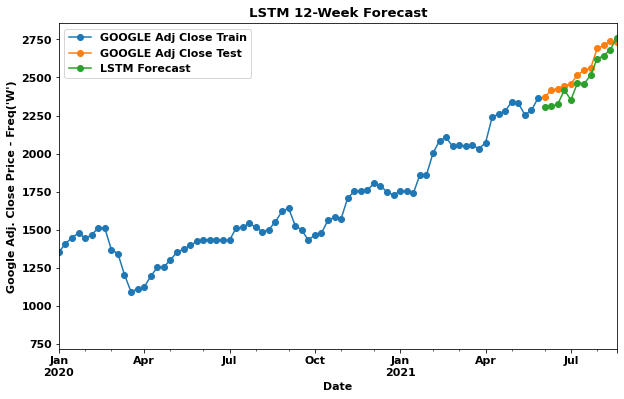

In [23]:
# Adj.Close plots of train/test data & of the LSTM predictions
ax=df['GOOGL_Adj_Close'][:-target_seq_len].plot(figsize=(10,6),marker='o',linestyle='-',label='GOOGLE Adj Close Train')
df['GOOGL_Adj_Close'][-target_seq_len:].plot(marker='o',linestyle='-',label='GOOGLE Adj Close Test')
new_pred_data.plot(ax=ax,legend=True,marker='o',linestyle='-')
plt.legend()
plt.title('LSTM 12-Week Forecast',fontweight='bold')
plt.ylabel("Google Adj. Close Price - Freq('W')",fontweight='bold')
plt.xlabel('Date',fontweight='bold')
plt.xlim('2020-01-01',today)